In [ ]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

#Import

In [ ]:
df = pd.read_excel("Sample - Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


Furniture sales time series analysis and forecasting

In [ ]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

#Data Preprocessing 

In [ ]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
furniture.isnull().sum()


Order Date    0
Sales         0
dtype: int64

In [ ]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [ ]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

In [ ]:
y = furniture['Sales'].resample('MS').mean()

In [ ]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

#preprocessing

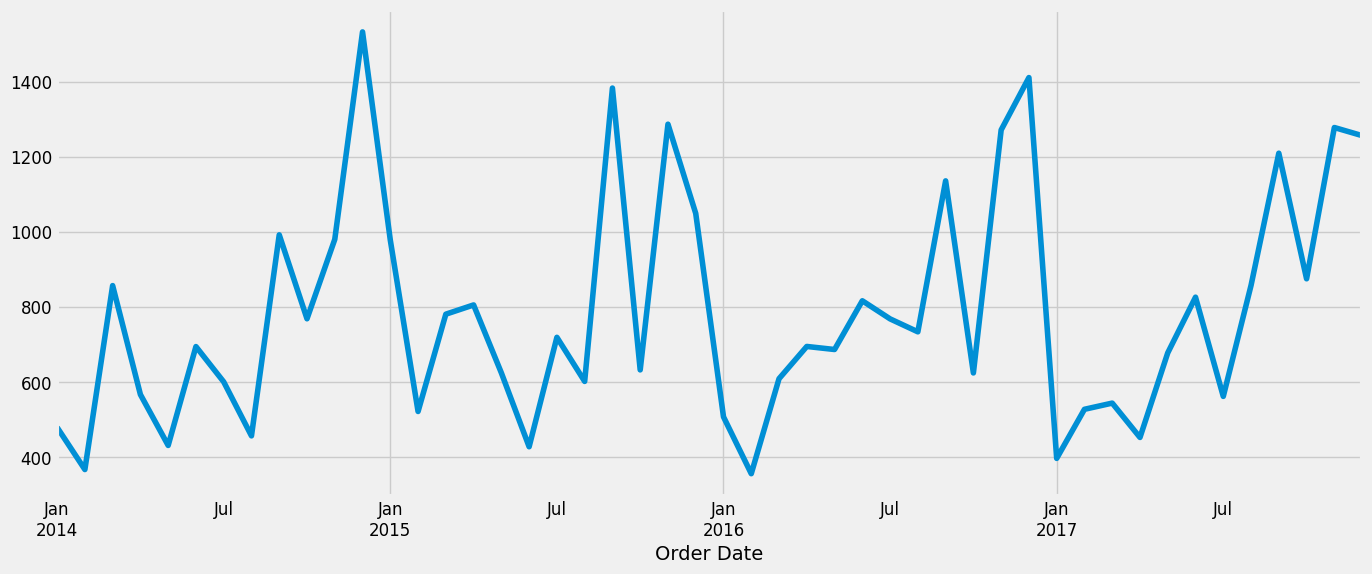

In [ ]:
y.plot(figsize=(15, 6))
plt.show()

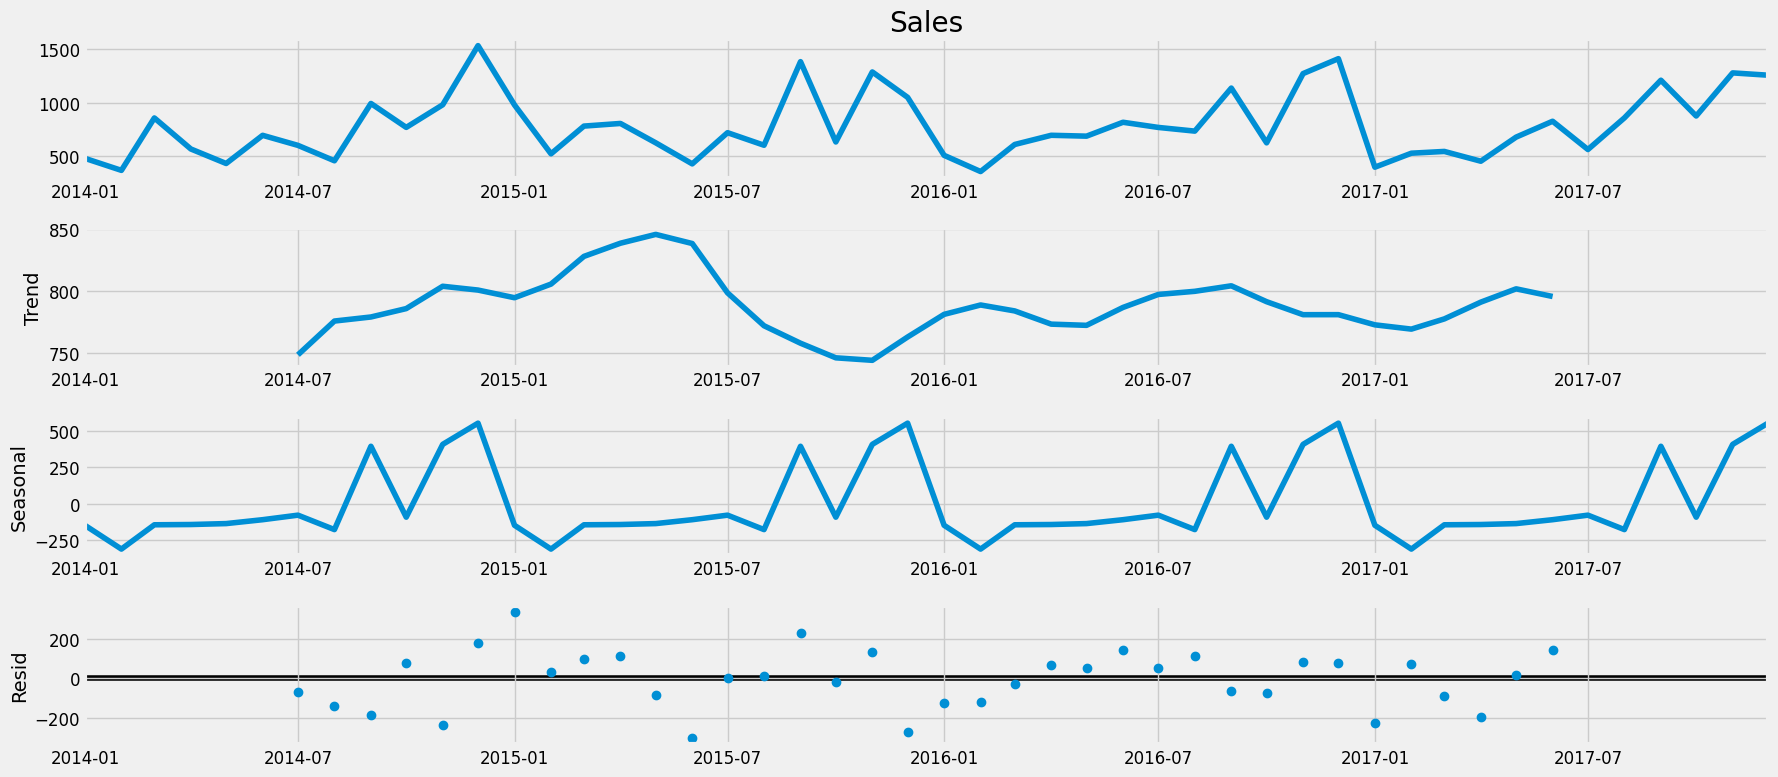

In [ ]:
# check for trend, seasonality sand residual 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()
plt.show()

#Model building

In [ ]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:769.0817523205915
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1523.5085449297978
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:477.7170130919703
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:302.27028997935736
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:497.2314433418338
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1317.1698862853953
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:318.0047199116341
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:304.24882803033336
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:720.9252270758099
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2715.646290524748
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:466.56074298091517
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:291.6261389673299
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:499.61482929923943
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2505.9754087946067
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:319.9884876946868
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:291.8725576437098
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:677.8947668259312
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1362.3338317546836
AR

In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0676      0.226      0.299      0.765      -0.376       0.511
ma.L1         -1.0000      0.279     -3.590      0.000      -1.546      -0.454
ar.S.L12      -0.4807      0.147     -3.260      0.001      -0.770      -0.192
sigma2      4.108e+04   6.78e-06   6.06e+09      0.000    4.11e+04    4.11e+04


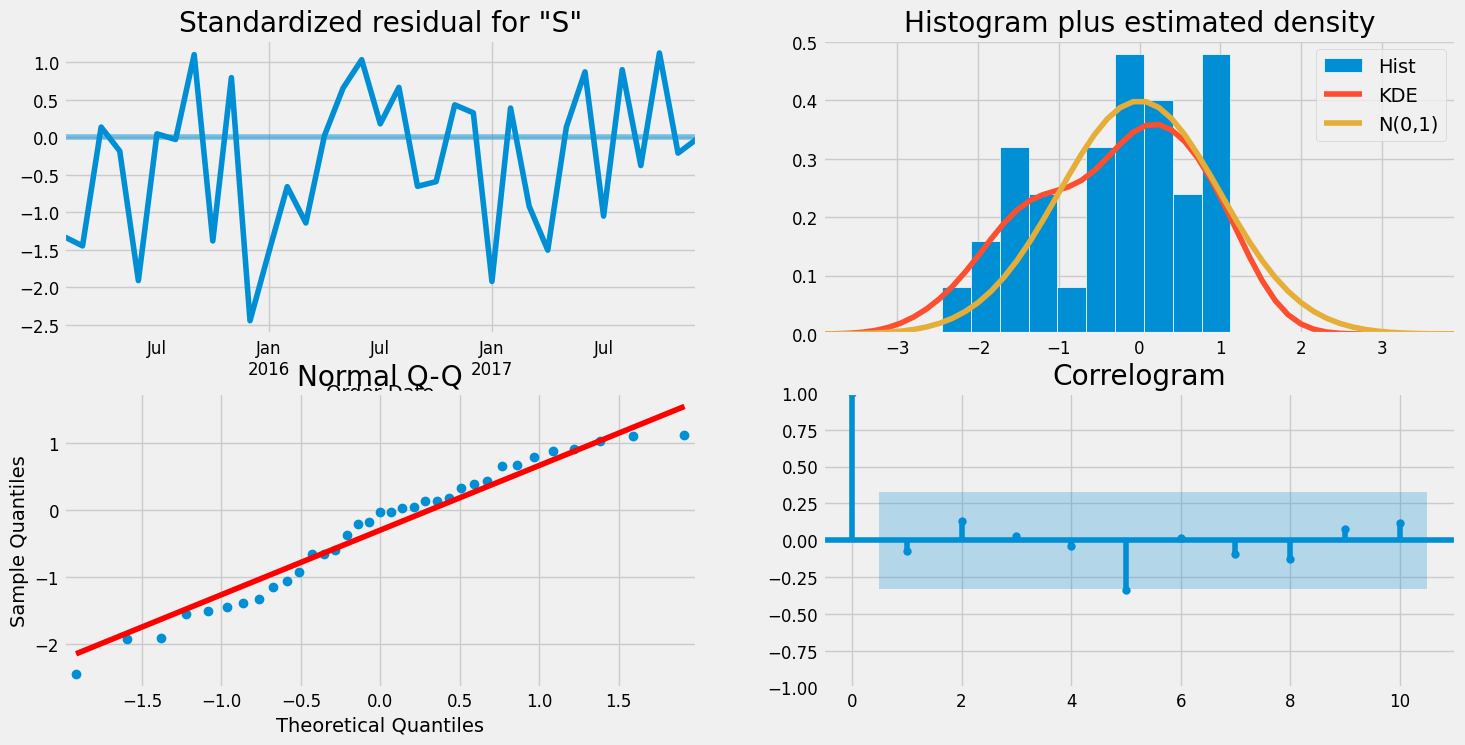

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

#Validation

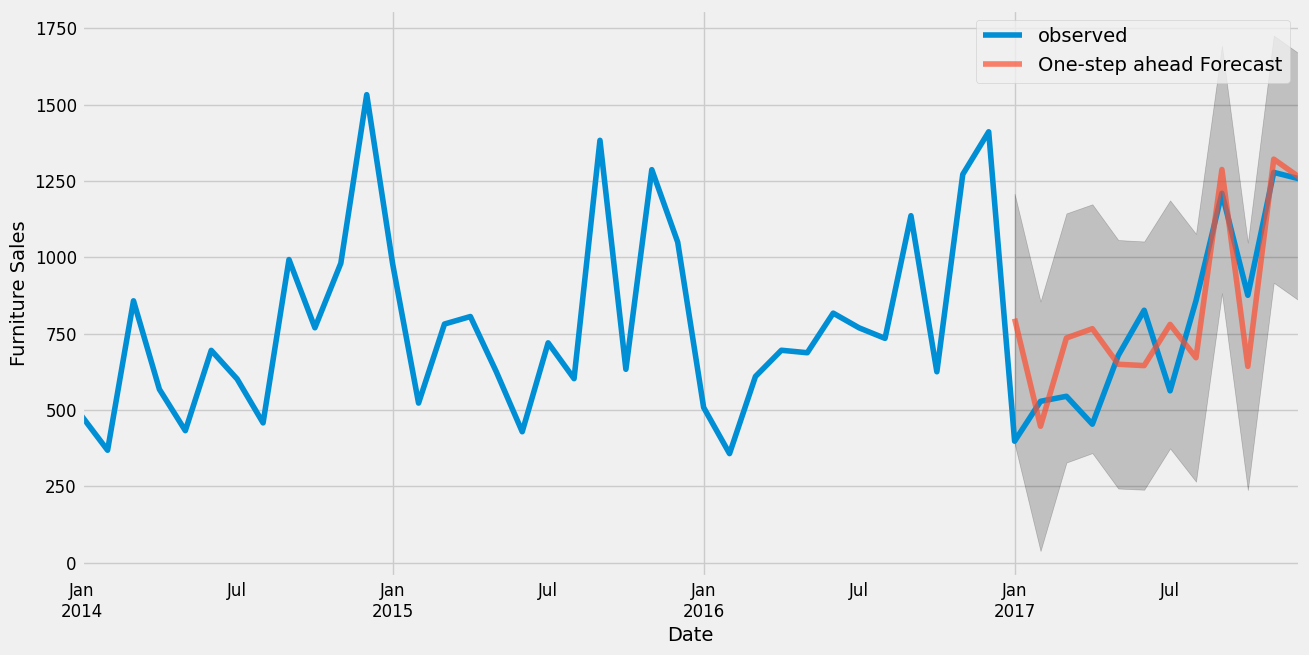

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 39996.01


In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 199.99


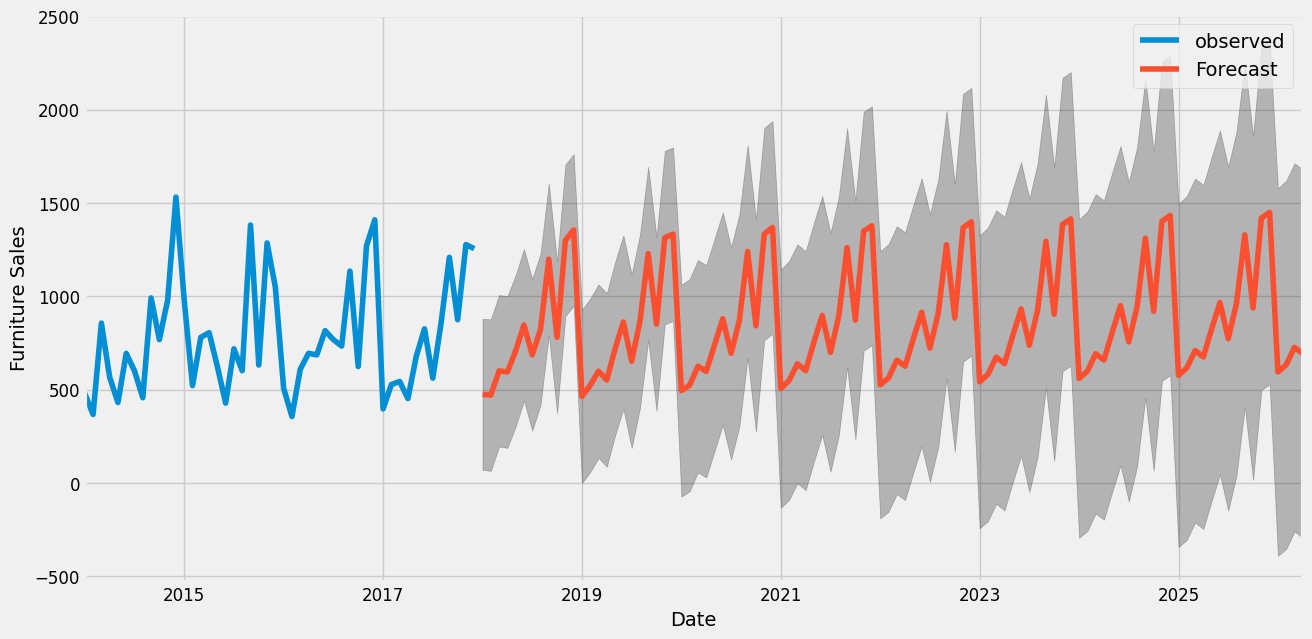

In [ ]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()
plt.show()

In [ ]:
furniture

,Sales
Order Date,
2014-01-06,2573.8200
2014-01-07,76.7280
2014-01-10,51.9400
2014-01-11,9.9400
2014-01-13,879.9390
...,...
2017-12-24,1393.4940
2017-12-25,832.4540
2017-12-28,551.2568


In [ ]:
furniture.to_csv('superstore.csv')